# Import Library + Load Dataset


In [254]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import matplotlib.pyplot as plt

# Set device and random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and explore data
df = pd.read_csv("/kaggle/input/dataset-berita/Kategori_Berita_Dataset.csv")
print("Dataset shape:", df.shape)
print(df.head())
print("\nKategori distribution:")
print(df['kategori'].value_counts())

Using device: cuda
Dataset shape: (100, 4)
                                               judul  \
0  Apriyani Rahayu Sudah Berlatih Lagi, Ingin Com...   
1  Hasil Korea Masters 2024: Putri KW Lanjut ke 1...   
2  Fajar/Rian di Japan dan China Masters: Inginny...   
3    Hasil Korea Masters 2024: Komang Ayu Tersingkir   
4  Korea Masters 2024 Hari Kedua: Tiga Wakil RI B...   

                       tanggal  \
0  Rabu, 06 Nov 2024 15:25 WIB   
1  Rabu, 06 Nov 2024 14:36 WIB   
2  Rabu, 06 Nov 2024 14:13 WIB   
3  Rabu, 06 Nov 2024 12:45 WIB   
4  Rabu, 06 Nov 2024 10:55 WIB   

                                                 isi  kategori  
0  Jakarta - Atlet bulutangkis Indonesia Apriyani...  Olahraga  
1  Jakarta - Putri Kusuma Wardani hadapi wakil Ta...  Olahraga  
2  Jakarta - Fajar Alfian/Muhammad Rian Ardianto ...  Olahraga  
3  Jakarta - Komang Ayu Cahya Dewi hadapi Liang T...  Olahraga  
4  Jakarta - Turnamen Korea Masters 2024 memasuki...  Olahraga  

Kategori distribution:
k

# Preprocessing (bersihkan teks)

In [255]:
def clean_text(text):
    text = str(text).lower()
    # Keep Indonesian words and remove only punctuation
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation but keep alphanumeric
    text = re.sub(r'\s+', ' ', text).strip()  # Multiple spaces to single space
    text = re.sub(r'\d+', '', text).strip()  # Remove numbers
    return text

# Apply text cleaning
df['clean_text'] = df['isi'].apply(clean_text)

# Filter out very short texts
df = df[df['clean_text'].str.len() > 10].reset_index(drop=True)
print(f"After filtering short texts: {len(df)} samples")

After filtering short texts: 100 samples


# Tokenisasi sederhana (build vocab sendiri)

In [256]:
def build_vocab(texts, min_freq=3, max_vocab_size=10000):
    counter = Counter()
    for txt in texts:
        words = txt.split()
        counter.update(words)
    
    vocab = {"<PAD>": 0, "<UNK>": 1}
    
    # Sort by frequency and take top words
    most_common = counter.most_common(max_vocab_size - 2)
    for word, freq in most_common:
        if freq >= min_freq and len(word) > 2:  # Filter very short words
            vocab[word] = len(vocab)
    
    return vocab

vocab = build_vocab(df['clean_text'])
print(f"Vocab size: {len(vocab)}")

Vocab size: 1807


# Encode text jadi angka

In [257]:
def encode_text(text, vocab, max_len=150):
    tokens = [vocab.get(word, vocab["<UNK>"]) for word in text.split()]
    # Truncate if too long
    if len(tokens) > max_len:
        tokens = tokens[:max_len]
    return tokens

# Encode texts
df['encoded'] = df['clean_text'].apply(lambda x: encode_text(x, vocab))

text_lengths = [len(text) for text in df['encoded']]
print(f"Text length stats: mean={np.mean(text_lengths):.1f}, std={np.std(text_lengths):.1f}")
print(f"Text length range: {min(text_lengths)} - {max(text_lengths)}")

Text length stats: mean=136.4, std=38.5
Text length range: 3 - 150


# Dataset & Dataloader

In [258]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create label mapping
unique_labels = sorted(df['kategori'].unique())
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}
print(f"Label mapping: {label_to_id}")

# Collate function
def collate_batch(batch):
    texts, labels = zip(*batch)
    
    # Pad sequences
    texts = pad_sequence([torch.tensor(x, dtype=torch.long) for x in texts],
                         batch_first=True, padding_value=vocab["<PAD>"])
    
    # Convert labels to tensor
    labels = torch.tensor([label_to_id[l] for l in labels], dtype=torch.long)
    
    return texts, labels

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['encoded'], df['kategori'], test_size=0.2, random_state=42, stratify=df['kategori']
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Create datasets
train_dataset = NewsDataset(list(X_train), list(y_train))
test_dataset = NewsDataset(list(X_test), list(y_test))

# Simple data loaders without weighted sampling initially
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)

Label mapping: {'Olahraga': 0, 'Otomotif': 1}
Training samples: 80
Test samples: 20


# Model RNN (LSTM)

In [259]:
class ImprovedRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.3):
        super(ImprovedRNNClassifier, self).__init__()
        
        # Embedding layer with proper initialization
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, 
                           batch_first=True, dropout=dropout, bidirectional=True)
        
        # Attention mechanism (simple)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Classification layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    
    def forward(self, x, return_attention=False):
        # Get mask for padding
        mask = (x != 0).float()
        
        # Embedding
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]
        
        # LSTM
        lstm_out, _ = self.lstm(embedded)  # [batch, seq_len, hidden_dim*2]
        
        # Attention mechanism
        attention_weights = torch.tanh(self.attention(lstm_out))  # [batch, seq_len, 1]
        attention_weights = attention_weights.squeeze(-1)  # [batch, seq_len]
        
        # Mask attention weights for padding tokens
        attention_weights = attention_weights.masked_fill(mask == 0, -1e9)
        attention_weights = torch.softmax(attention_weights, dim=1)  # [batch, seq_len]
        
        # Apply attention
        attended = torch.bmm(attention_weights.unsqueeze(1), lstm_out)  # [batch, 1, hidden_dim*2]
        attended = attended.squeeze(1)  # [batch, hidden_dim*2]
        
        # Classification
        out = self.dropout(attended)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        if return_attention:
            return out, attention_weights
        return out

# Initialize model with smaller dimensions to prevent overfitting
model = ImprovedRNNClassifier(
    vocab_size=len(vocab), 
    embed_dim=64,  # Reduced from 100
    hidden_dim=64,  # Reduced from 128
    output_dim=len(unique_labels),
    dropout=0.5  # Increased dropout
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 290,051


# Training

In [260]:
# Loss and optimizer with regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(loader), 100 * correct / total

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(loader), 100 * correct / total

# Training loop with early stopping
num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0
patience = 7
patience_counter = 0

print("Starting training...")
for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {current_lr:.6f}")
    
    # Early stopping and best model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'vocab': vocab,
            'label_to_id': label_to_id,
            'id_to_label': id_to_label
        }, 'best_model.pt')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"  Early stopping after {patience} epochs without improvement")
            break
    
    print("-" * 50)

# Load best model
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model with validation accuracy: {checkpoint['val_acc']:.2f}%")

Starting training...
Epoch 1/30
  Train Loss: 0.6944, Train Acc: 45.00%
  Val Loss: 0.6936, Val Acc: 50.00%
  LR: 0.001000
  ✓ New best model saved! (Val Acc: 50.00%)
--------------------------------------------------
Epoch 2/30
  Train Loss: 0.6925, Train Acc: 47.50%
  Val Loss: 0.6924, Val Acc: 55.00%
  LR: 0.001000
  ✓ New best model saved! (Val Acc: 55.00%)
--------------------------------------------------
Epoch 3/30
  Train Loss: 0.6915, Train Acc: 60.00%
  Val Loss: 0.6897, Val Acc: 90.00%
  LR: 0.001000
  ✓ New best model saved! (Val Acc: 90.00%)
--------------------------------------------------
Epoch 4/30
  Train Loss: 0.6876, Train Acc: 58.75%
  Val Loss: 0.6852, Val Acc: 100.00%
  LR: 0.001000
  ✓ New best model saved! (Val Acc: 100.00%)
--------------------------------------------------
Epoch 5/30
  Train Loss: 0.6837, Train Acc: 66.25%
  Val Loss: 0.6782, Val Acc: 75.00%
  LR: 0.001000
--------------------------------------------------
Epoch 6/30
  Train Loss: 0.6622, Tra

# Evaluasi


FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Olahraga       1.00      1.00      1.00        10
    Otomotif       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



<Figure size 800x600 with 0 Axes>

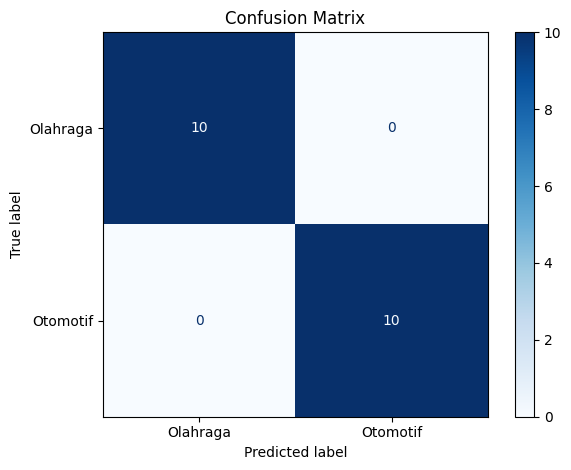

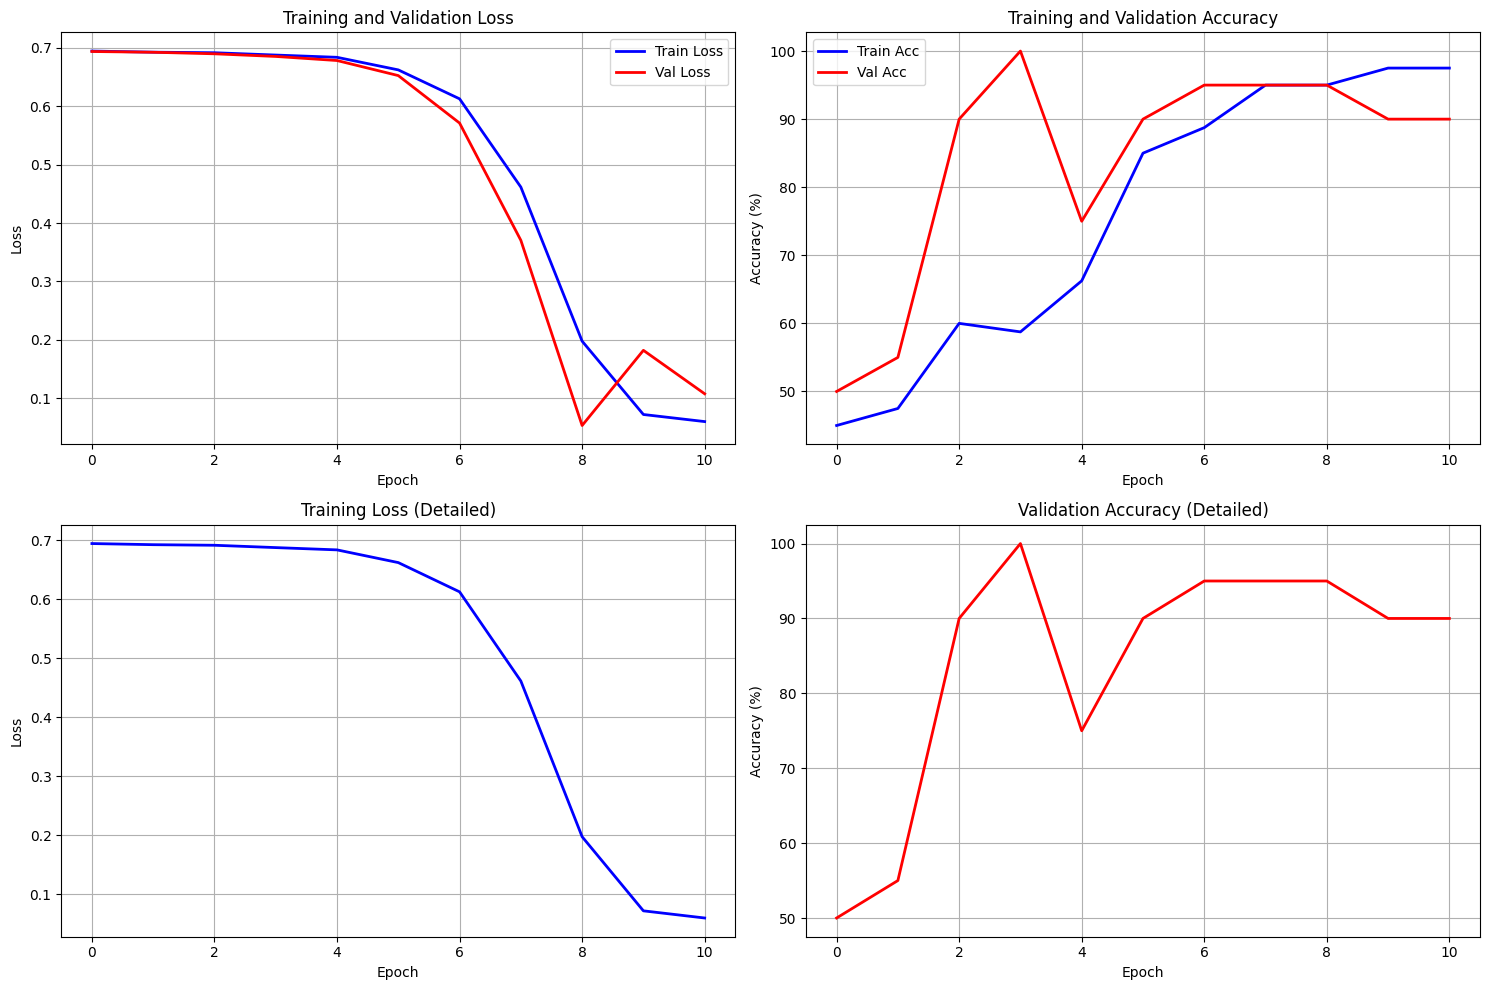

In [261]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
target_names = [id_to_label[i] for i in range(len(unique_labels))]
print("\n" + "="*50)
print("FINAL CLASSIFICATION REPORT")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Plot training curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
ax1.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(train_accs, 'b-', label='Train Acc', linewidth=2)
ax2.plot(val_accs, 'r-', label='Val Acc', linewidth=2)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

# Loss zoom
ax3.plot(train_losses, 'b-', linewidth=2)
ax3.set_title('Training Loss (Detailed)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.grid(True)

# Accuracy zoom
ax4.plot(val_accs, 'r-', linewidth=2)
ax4.set_title('Validation Accuracy (Detailed)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy (%)')
ax4.grid(True)

plt.tight_layout()
plt.show()

# Prediksi Beberapa Berita

In [262]:
# Enhanced prediction function
def predict_texts_enhanced(text_list, model, vocab, label_mapping, device, max_len=150):
    model.eval()
    results = []
    
    with torch.no_grad():
        for txt in text_list:
            # Clean and encode
            clean = clean_text(txt)
            encoded = encode_text(clean, vocab, max_len)
            
            # Convert to tensor
            tensor = torch.tensor([encoded], dtype=torch.long).to(device)
            
            # Get predictions with attention
            output, attention = model(tensor, return_attention=True)
            probabilities = torch.softmax(output, dim=1)
            pred = torch.argmax(output, dim=1).item()
            confidence = probabilities[0][pred].item()
            
            # Get top predictions
            top_probs, top_indices = torch.topk(probabilities[0], k=min(3, len(label_mapping)))
            top_predictions = [(label_mapping[idx.item()], prob.item()) 
                             for idx, prob in zip(top_indices, top_probs)]
            
            label = label_mapping[pred]
            results.append((txt, label, confidence, top_predictions))
    
    return results

# Test with sample texts
sample_texts = [
    "Messi berhasil membawa Argentina juara Copa America dengan performa luar biasa",
    "Honda resmi meluncurkan motor sport terbaru di Indonesia dengan teknologi canggih",
    "Cristiano Ronaldo mencetak gol penentu kemenangan dalam pertandingan penting",
    "Toyota memperkenalkan mobil listrik terbaru untuk pasar Asia dengan inovasi ramah lingkungan",
    "Pertandingan final Liga Champions akan digelar malam ini dengan antusiasme tinggi",
    "BMW mengumumkan kendaraan otonom terbaru mereka dengan fitur keselamatan canggih",
    "Sepak bola Indonesia menunjukkan kemajuan pesat di level internasional",
    "Industri otomotif Indonesia berkembang dengan produksi kendaraan yang meningkat"
]

print("\n" + "="*70)
print("CONTOH PREDIKSI BARU")
print("="*70)
predictions = predict_texts_enhanced(sample_texts, model, vocab, id_to_label, device)

for txt, label, confidence, top_preds in predictions:
    print(f"Teks: {txt}")
    print(f"➡️ Prediksi Utama: {label} (Confidence: {confidence:.3f})")
    print()  # Tambah baris kosong


CONTOH PREDIKSI BARU
Teks: Messi berhasil membawa Argentina juara Copa America dengan performa luar biasa
➡️ Prediksi Utama: Olahraga (Confidence: 0.504)

Teks: Honda resmi meluncurkan motor sport terbaru di Indonesia dengan teknologi canggih
➡️ Prediksi Utama: Otomotif (Confidence: 0.508)

Teks: Cristiano Ronaldo mencetak gol penentu kemenangan dalam pertandingan penting
➡️ Prediksi Utama: Olahraga (Confidence: 0.503)

Teks: Toyota memperkenalkan mobil listrik terbaru untuk pasar Asia dengan inovasi ramah lingkungan
➡️ Prediksi Utama: Otomotif (Confidence: 0.506)

Teks: Pertandingan final Liga Champions akan digelar malam ini dengan antusiasme tinggi
➡️ Prediksi Utama: Olahraga (Confidence: 0.504)

Teks: BMW mengumumkan kendaraan otonom terbaru mereka dengan fitur keselamatan canggih
➡️ Prediksi Utama: Olahraga (Confidence: 0.500)

Teks: Sepak bola Indonesia menunjukkan kemajuan pesat di level internasional
➡️ Prediksi Utama: Olahraga (Confidence: 0.506)

Teks: Industri otomotif Indo